# Download an image using the IIIF server and a Handle url

[IIIF](https://iiif.io/) (the International Image Interoperability Framework) has defined a set of standards for publishing and using image collections. The State Library of Victoria makes many of its images available from an IIIF-compliant server. This means you can access and manipulate the images in standard ways set out by the [IIIF Image API](https://iiif.io/api/image/2.1/).

Many images in the State Library's collection also have a permanent url, created using the Handle system. These are displayed in Trove. But there's no obvious way of getting an IIIF image from a Handle. Of course, if you're a human you can load the image page in your browser and click on the download button. But what if you want to build a processing pipeline, or create a dataset of images? Wouldn't it be good if you could just supply a Handle url and get back an image in whatever format or size you wanted? That's what this notebook does.

## Setting things up

In [1]:
import re
from pathlib import Path

import requests
from IPython.display import Image, display

In [4]:
def get_pid(handle_url):
    """
    Extract a pid (image identifier) from the image viewer url.
    """
    # The handle url will get redirected to a system url that includes a pid
    response = requests.get(handle_url)

    # Get the pid from the redirected url
    match = re.search(r"entity=(IE\d+)", response.url)
    if match:
        return match.group(1)


def get_image_ids(manifest):
    """
    Extract a list of image @ids from an IIIF manifest
    """
    image_ids = []
    # There can be multiple images in a record
    # So we loop through the canvases to get each one.
    for canvas in manifest["sequences"][0]["canvases"]:
        image_ids.append(canvas["images"][0]["resource"]["service"]["@id"])
    return image_ids


def construct_image_url(image_id, image_type, max_width, max_height):
    """
    Construct a url to download the image according to the IIIF standard.
    """
    # Create a string with the size information -- either 'w,h', 'w,', ',h', or 'max'
    if max_width and max_height:
        size = f"!{max_width},{max_height}"
    elif max_width:
        size = f"{max_width},"
    elif max_height:
        size = f",{max_height}"
    else:
        size = "max"
    # Construct the url
    return f"{image_id}/full/{size}/0/default.{image_type}"


def download_image(handle_url, image_type="jpg", max_width=None, max_height=None):
    """
    Downloads a derivative image from the IIIF server using its Handle, and saves
    it to the 'images' folder.
    Params:
        handle_url: the Handle link for this image (required)
        image_type: one of 'jpg', 'tif', 'png'
        max_width: maximum width in pixels
        max_height: maximum height in pixels
    """
    pid = get_pid(handle_url)
    manifest_url = f"https://rosetta.slv.vic.gov.au/delivery/iiif/presentation/2.1/{pid}/manifest.json"

    # Get the IIIF manifest
    response = requests.get(manifest_url)
    manifest = response.json()
    print(f"Manifest: {response.url}")

    # Extract the image ids from the manifest
    image_ids = get_image_ids(manifest)

    # Make sure there's somewhere to save the images
    Path("images").mkdir(parents=True, exist_ok=True)

    #  Loop through the image ids, downloading each image
    for index, image_id in enumerate(image_ids):

        # I've noticed some image ids lead to 404 errors
        # we'll filter those out here.
        response = requests.get(image_id)
        if response.ok:

            # Construct a filename using the image pid and a numeric index
            filename = Path(f"images/slv-{pid}-{index}.{image_type}")

            # Construct an IIIF compliant url
            image_url = construct_image_url(image_id, image_type, max_width, max_height)

            # Download and save the image
            response = requests.get(image_url)
            filename.write_bytes(response.content)

            # Display the image if possible
            if image_type in ["jpg", "png"]:
                display(Image(response.content, width=500))

## Downloading an image

To download an image (or images) from a Handle url, just copy and paste the url into the cell below. By default, this will download the largest available version of the image in jpeg format. You can modify this behaviour by supplying any of the following parameters:

* `image_type`: one of 'jpg', 'tif', 'png'
* `max_width`: maximum width of the image in pixels
* `max_height`: maximum height of the image in pixels

For example to get a fullsize TIFF version:

```
download_image('http://handle.slv.vic.gov.au/10381/282282', image_type='tif')
```

To get a PNG file that's 200 pixels wide:

```
download_image('http://handle.slv.vic.gov.au/10381/282282', image_type='png', max_width=200)
```

You'll find the downloaded image(s) in the `images` directory.

Manifest: https://rosetta.slv.vic.gov.au/delivery/iiif/presentation/2.1/IE1164978/manifest.json


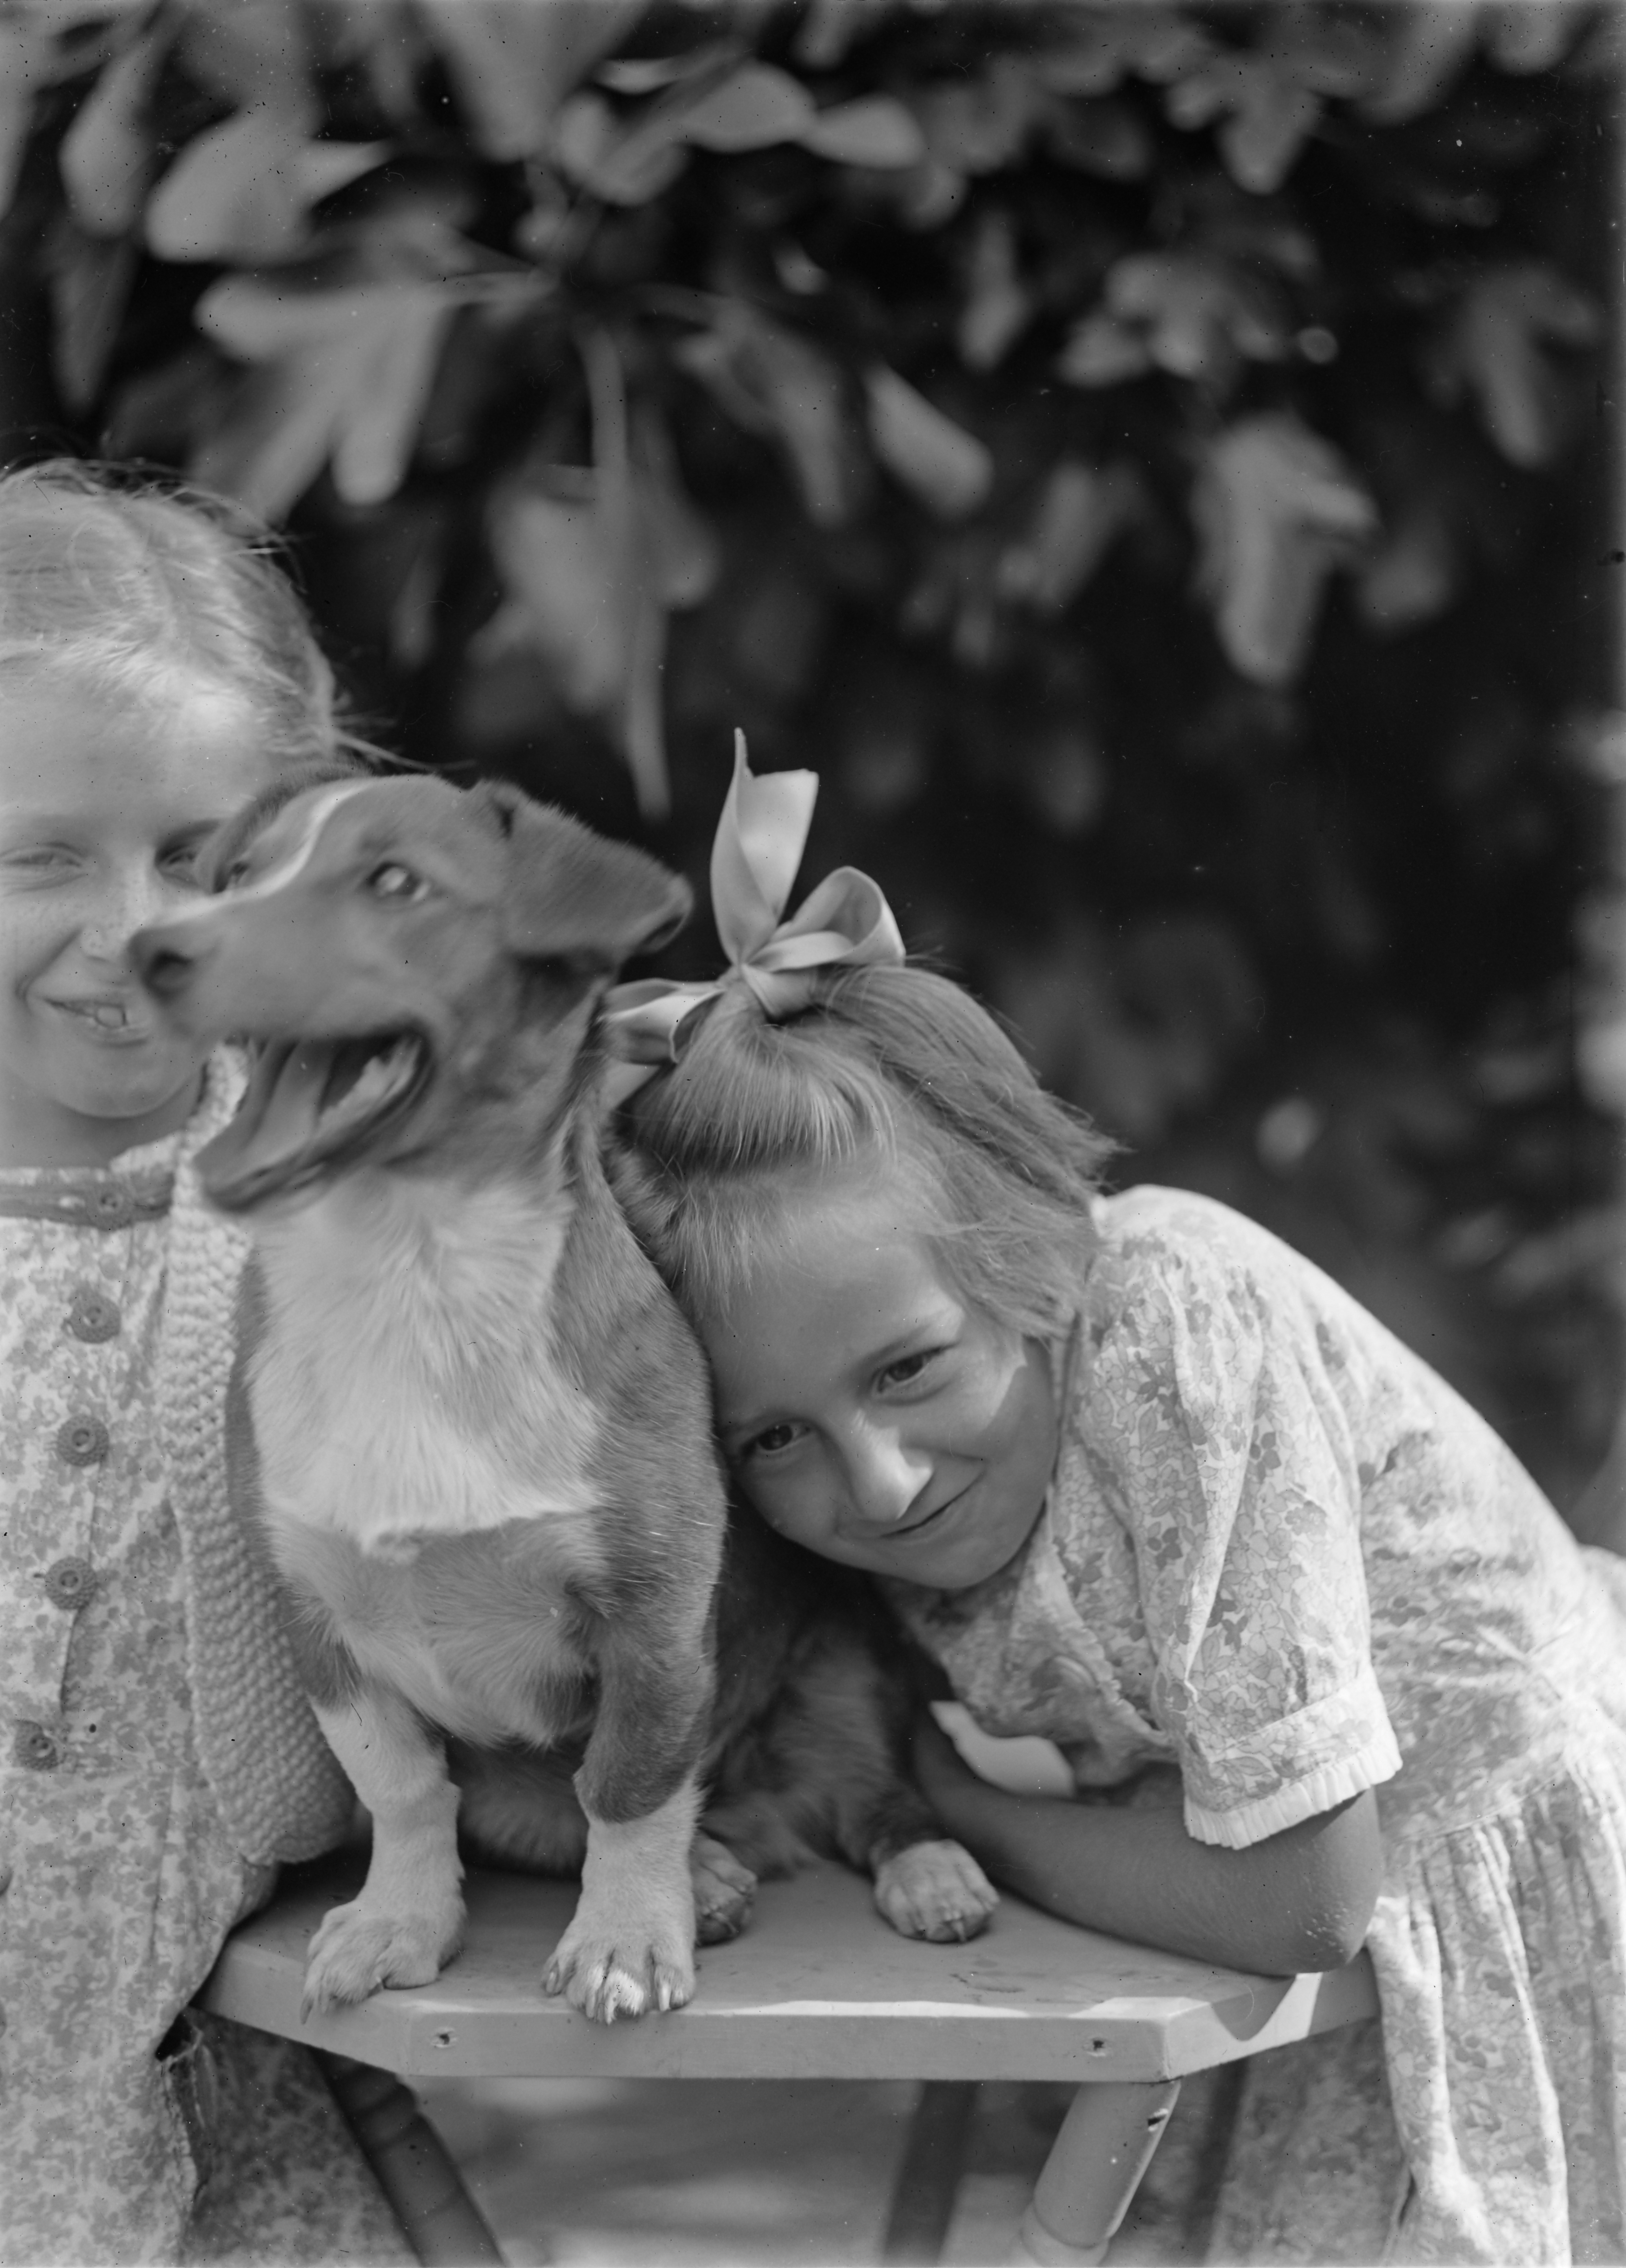

In [5]:
# Paste a Handle url between the quotes
download_image("http://handle.slv.vic.gov.au/10381/25896")

Of course there's a lot more fun things you can do with IIIF – we'll explore that in [another notebook](more_fun_with_iiif.ipynb)...

----

Created by [Tim Sherratt](https://timsherratt.au) for the [GLAM Workbench](https://glam-workbench.net). If you find this useful, you can [sponsor me on GitHub](https://github.com/sponsors/wragge).